In [1]:
# Version 3


# Table of Contents 
#   Import Data
#   Feature Engineering
#     Split/Train/Normalize
#     Data Windowing
#   Single Step Models
#   (The multi input, single step models perform the best)

#     Baseline, Linear, Dense, Multi-Step Dense, Convolution NN, Recurrent NN
#     Performance Comparison
#   Multi-Step Models 
#   (These don't perform as well as the multi input, single step predictions)
#     Baseline, Single-Shot, AutoRegressive (Back Propagation)
#     Performance Comparison

In [2]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from google.colab import drive

In [3]:
# Mount Google Drive so we can access it
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# List files in our shared drive so we know what we need
!ls 'gdrive/Shareddrives/CPSC 4176 Project Spring 2023/UAV Data'

In [4]:
from google.colab import files
uav4_file = files.upload()

Saving UAV_4_Data_down.xlsx to UAV_4_Data_down.xlsx


In [8]:
uav4_file.keys()

dict_keys(['UAV_4_Data_down.xlsx'])

In [9]:
# Read data into pandas dataframe
# Extracts all 5 lane "sheets" into a dictionary of dataframes
# This takes ~5 minutes and still only consists of one direction of UAV4 highway
url = "gdrive/Shareddrives/CPSC 4176 Project Spring 2023/UAV Data/UAV_4_Data_down.xlsx"
uav4_dict_df = pd.read_excel(uav4_file['UAV_4_Data_down.xlsx'], sheet_name=["Sheet1", "sheet2", "sheet3", "sheet4", "sheet5"])
# TODO: Add UAV4 Up data

In [10]:
# Feature Engineering
# Merge all dataframes into one dataframe
# TODO: I have no idea why a loop doesn't work. Looping makes blank df.
vehicle_data = pd.concat([uav4_dict_df['Sheet1'], uav4_dict_df['sheet2']])
vehicle_data = pd.concat([vehicle_data, uav4_dict_df['sheet3']])
vehicle_data = pd.concat([vehicle_data, uav4_dict_df['sheet4']])
vehicle_data = pd.concat([vehicle_data, uav4_dict_df['sheet5']])
# View dataframe snippet and shape (rows x columns = shape (rows, columns))
vehicle_data

,VehicleID,LaneID,Time(s),x-axis position(m),Distance from upper Lane line(m),Distance from lower lane line(m),Speed(m/s),Acceleration(m/s^2),VehicleLength(meter),VehicleWidth(meter)
0,7,1,0.03333,292.885000,1.516244,2.058017,17.160722,0.147550,5.101913,2.058609
1,7,1,0.06666,293.456967,1.523727,2.049199,17.165635,0.141271,5.101913,2.058609
2,7,1,0.09999,294.029097,1.531513,2.040078,17.170339,0.186334,5.101913,2.058609
3,7,1,0.13332,294.601385,1.539330,2.030925,17.176544,0.203683,5.101913,2.058609
4,7,1,0.16665,295.173879,1.547176,2.021743,17.183327,0.195536,5.101913,2.058609
...,...,...,...,...,...,...,...,...,...,...
9324,14636,5,1166.21670,304.726754,0.073932,3.202921,17.014972,0.264952,4.608019,2.160101
9325,14636,5,1166.25003,305.293863,0.059896,3.212419,17.023795,0.271473,4.608019,2.160101
9326,14636,5,1166.28336,305.861266,0.045632,3.222144,17.032835,0.264751,4.608019,2.160101
9327,14636,5,1166.31669,306.428971,0.031139,3.232095,17.041652,0.286796,4.608019,2.160101


In [11]:
# Displays statistical information
vehicle_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
VehicleID,1491806.0,7549.011885,4401.206952,3.000000,3739.000000,7658.000000,11513.000000,15134.000000
LaneID,1491806.0,2.221325,1.048291,1.000000,1.000000,2.000000,3.000000,5.000000
Time(s),1491806.0,631.091405,342.883293,0.033330,349.398390,647.468580,940.005990,1184.714850
x-axis position(m),1491806.0,177.669180,99.549218,2.850000,93.567696,176.489287,261.972571,357.835707
Distance from upper Lane line(m),1491806.0,1.054942,0.855464,0.000008,0.520142,0.796154,1.225295,4.609750
Distance from lower lane line(m),1491806.0,2.564042,0.860321,0.000014,2.328079,2.720643,3.052481,4.610906
Speed(m/s),1491806.0,14.830025,2.339351,2.188760,13.246879,14.770075,16.365010,26.082532
Acceleration(m/s^2),1491806.0,0.014293,0.902819,-137.975116,-0.173763,0.023538,0.222216,227.341051
VehicleLength(meter),1491806.0,4.701725,1.011891,2.754520,4.387694,4.584783,4.759123,13.300000
VehicleWidth(meter),1491806.0,2.033243,0.217187,1.640053,1.946616,2.013002,2.069078,4.180000


In [12]:
# Data Normalization
# TODO: Update to H&D's normalized data

# We need to normalize the data between 0 and 1
# data' is normalized between 0 and 1
# data' = (data - data_min) / (data_max - data_min)

def NormalizeData(data):
  return (data - np.min(data)) / (np.max(data) - np.min(data))

vehicle_data = NormalizeData(vehicle_data)
# Because I have 'Speed' in many places, I found it easier to just relabel this
vehicle_data.rename(columns={'Speed(m/s)':'Speed'}, inplace=True)

# Display and Confrim min/max normalization
print("\nVehicle Data Maximums")
print(vehicle_data.max())
print("\nVehicle Data Minimums")
print(vehicle_data.min())

# TODO: Where did the NaN's go????
vehicle_data

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)



Vehicle Data Maximums
VehicleID                           1.0
LaneID                              1.0
Time(s)                             1.0
x-axis position(m)                  1.0
Distance from upper Lane line(m)    1.0
Distance from lower lane line(m)    1.0
Speed                               1.0
Acceleration(m/s^2)                 1.0
VehicleLength(meter)                1.0
VehicleWidth(meter)                 1.0
dtype: float64

Vehicle Data Minimums
VehicleID                           0.0
LaneID                              0.0
Time(s)                             0.0
x-axis position(m)                  0.0
Distance from upper Lane line(m)    0.0
Distance from lower lane line(m)    0.0
Speed                               0.0
Acceleration(m/s^2)                 0.0
VehicleLength(meter)                0.0
VehicleWidth(meter)                 0.0
dtype: float64


,VehicleID,LaneID,Time(s),x-axis position(m),Distance from upper Lane line(m),Distance from lower lane line(m),Speed,Acceleration(m/s^2),VehicleLength(meter),VehicleWidth(meter)
0,0.000264,0.0,0.000000,0.817033,0.328920,0.446335,0.626605,0.378091,0.222597,0.164789
1,0.000264,0.0,0.000028,0.818644,0.330543,0.444423,0.626811,0.378074,0.222597,0.164789
2,0.000264,0.0,0.000056,0.820256,0.332232,0.442444,0.627008,0.378197,0.222597,0.164789
3,0.000264,0.0,0.000084,0.821868,0.333928,0.440459,0.627267,0.378244,0.222597,0.164789
4,0.000264,0.0,0.000113,0.823481,0.335630,0.438468,0.627551,0.378222,0.222597,0.164789
...,...,...,...,...,...,...,...,...,...,...
9324,0.967087,1.0,0.984386,0.850391,0.016037,0.694639,0.620505,0.378412,0.175762,0.204748
9325,0.967087,1.0,0.984414,0.851989,0.012992,0.696699,0.620875,0.378430,0.175762,0.204748
9326,0.967087,1.0,0.984442,0.853587,0.009897,0.698808,0.621253,0.378412,0.175762,0.204748
9327,0.967087,1.0,0.984470,0.855186,0.006753,0.700966,0.621622,0.378472,0.175762,0.204748


In [13]:
# Split data into training (70%), validation (20%), and test (10%) sets
# TODO: Update split and train, P got scikit to work. I believe my method 
# takes the first 70% as training instead of grabbing 70% randomly from the list
# which would be better, correct?

n = len(vehicle_data)
train_df = vehicle_data[0:int(n*0.7)]
val_df = vehicle_data[int(n*0.7):int(n*0.9)]
test_df = vehicle_data[int(n*0.9):]

num_features = vehicle_data.shape[1]
column_indices = {name: i for i, name in enumerate(vehicle_data.columns)}

In [14]:
# Data Windowing
# Our goal is to make a set of predictions based on a window of
# consecutive samples from the data
#   -width (num of time steps) of input and label windows
#   -time offset between them
#   -which features are used as inputs, labels, or both
# Example: to predict 24 time steps into the future with 24 time steps of data
#   input width = 24, offset = 24 (label width = 1), total width 48
# Example: predict 1 time step into future given 6 time steps of data
#   input width = 6, offset = 1 (label width = 1), total width = 7

# Our data is in time increments of 0.0333 seconds instead of 1 hour
# Number of time steps (row of data) to how much actual time
# (Number of time steps = seconds / 0.0333)
# 750 = ~25 seconds
# 1800 = ~60 seconds
# 9000 = ~5 minutes
# 36000 = ~20 minutes

# These are the values to be used in windowing. If we want to predict 60 seconds
# into the future, then we would need to expand the label width to 1800 using
# 5 minutes of data, then the input width should be 9000

# Window Generator
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

# WindowGenerator holds training, validation, and test data
# Add properties for accessing them as tf.data.Dataset
# Add standard example batch for easy access and plotting
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

# Converts a list of consecutive inputs to a window of inputs and labels
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

# Plot allows for simple visulization of the split window
def plot(self, model=None, plot_col='Speed', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [0.0333 seconds]')

# Takes a time series pd.dataframe and converts to a tf.data.Dataset
# of (input_window, label_window) pairs
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

In [15]:
# Initializes WindowGenertor to custom methods
WindowGenerator.split_window = split_window
WindowGenerator.plot = plot
WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [16]:
# Models

In [17]:
# We should establish a performance baseline as a point for comparison with
# the later more complicated models

# Baseline, predicts one time step into the future (0.0333 seconds)
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [18]:
# Creates a compile and fit method because we're using many models
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [19]:
# Windows

In [20]:
# IGNORE THIS, Only dealing with Speed currently, this will matter with more

# It's possible to examine the layers weights
# Random initialization doesn't always place most weight on temperature, main flaw of this

#plt.bar(x = range(len(train_df.columns)),
#        height=linear.layers[0].kernel[:,0].numpy())
#axis = plt.gca()
#axis.set_xticks(range(len(train_df.columns)))
#_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [21]:
# Multi-step models will take multiple time steps as input to produce a single output

# Initialize dict to store performance values
val_performance = {}
performance = {}

Total window size: 51
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [50]
Label column name(s): ['Speed']

Input shape: (32, 50, 10)
Output shape: (32, 1, 1) 

Epoch 1/20
32632/32632 [==============================] - 113s 3ms/step - loss: 1.9580e-04 - mean_absolute_error: 0.0071 - val_loss: 2.0282e-04 - val_mean_absolute_error: 0.0107
Epoch 2/20
32632/32632 [==============================] - 106s 3ms/step - loss: 9.8036e-05 - mean_absolute_error: 0.0047 - val_loss: 1.0947e-04 - val_mean_absolute_error: 0.0063
Epoch 3/20
32632/32632 [==============================] - 106s 3ms/step - loss: 8.5272e-05 - mean_absolute_error: 0.0042 - val_loss: 2.5980e-04 - val_mean_absolute_error: 0.0142
Epoch 4/20
9323/9323 [==============================] - 18s 2ms/step - loss: 1.4158e-04 - mean_absolute_error: 0.0089

Performance: [0.0001606387522770092, 0.01006016600

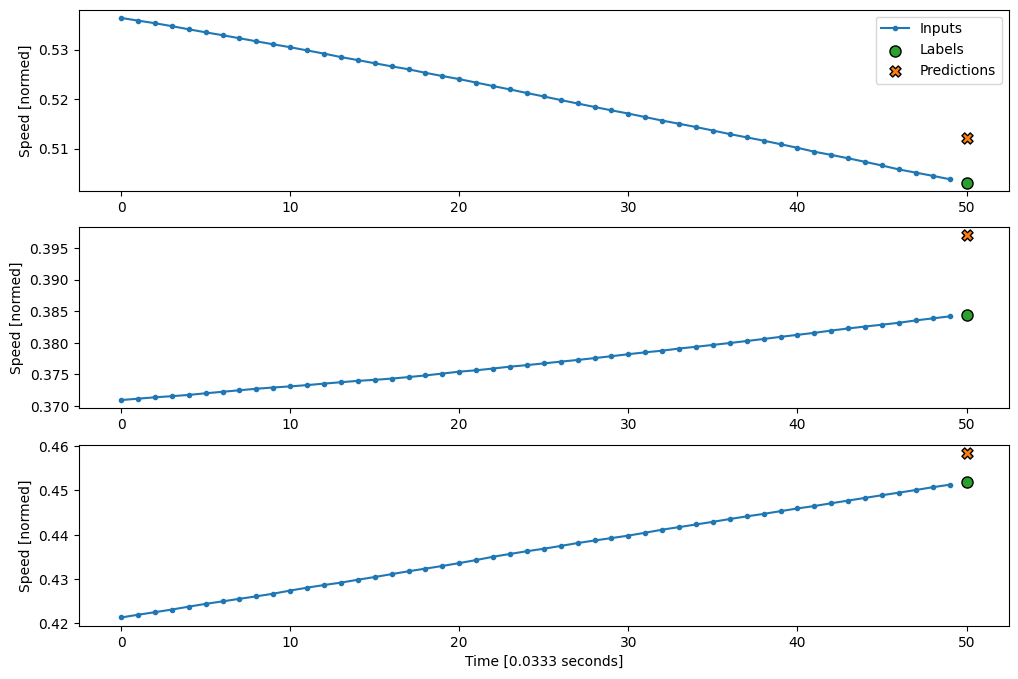

In [22]:
# Multi-Step Dense Model
# Creates batches of 50 time step inputs and 1 time step label
CONV_WIDTH = 50
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Speed'])

print(conv_window)

# Create Multi-Step Dense Model
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),])

# Down-side: can only be executed on input windows of exactly this shape
print('\nInput shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape, '\n')

# Train Multi-Step Dense Model 
history = compile_and_fit(multi_step_dense, conv_window)
# IPython.display.clear_output()

# Evaluate Multi-Step Dense Model
val_performance['Multi Step Dense CW'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi Step Dense CW'] = multi_step_dense.evaluate(conv_window.test, verbose=0)
print("\nPerformance:", performance['Multi Step Dense CW'], 
      "Val Performance:", val_performance['Multi Step Dense CW'])

# Plot Multi-Step Dense Model
conv_window.plot(multi_step_dense)

Total window size: 51
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [50]
Label column name(s): ['Speed']

Conv model on `conv_window`
Input shape: (32, 50, 10)
Output shape: (32, 1, 1) 

Epoch 1/20
32632/32632 [==============================] - 138s 4ms/step - loss: 2.1408e-04 - mean_absolute_error: 0.0078 - val_loss: 1.1086e-04 - val_mean_absolute_error: 0.0040
Epoch 2/20
32632/32632 [==============================] - 133s 4ms/step - loss: 1.0332e-04 - mean_absolute_error: 0.0050 - val_loss: 8.0880e-05 - val_mean_absolute_error: 0.0019
Epoch 3/20
32632/32632 [==============================] - 133s 4ms/step - loss: 8.7941e-05 - mean_absolute_error: 0.0044 - val_loss: 7.6426e-05 - val_mean_absolute_error: 0.0027
Epoch 4/20
32632/32632 [==============================] - 132s 4ms/step - loss: 8.1217e-05 - mean_absolute_error: 0.0041 - val_loss: 7.2412e-

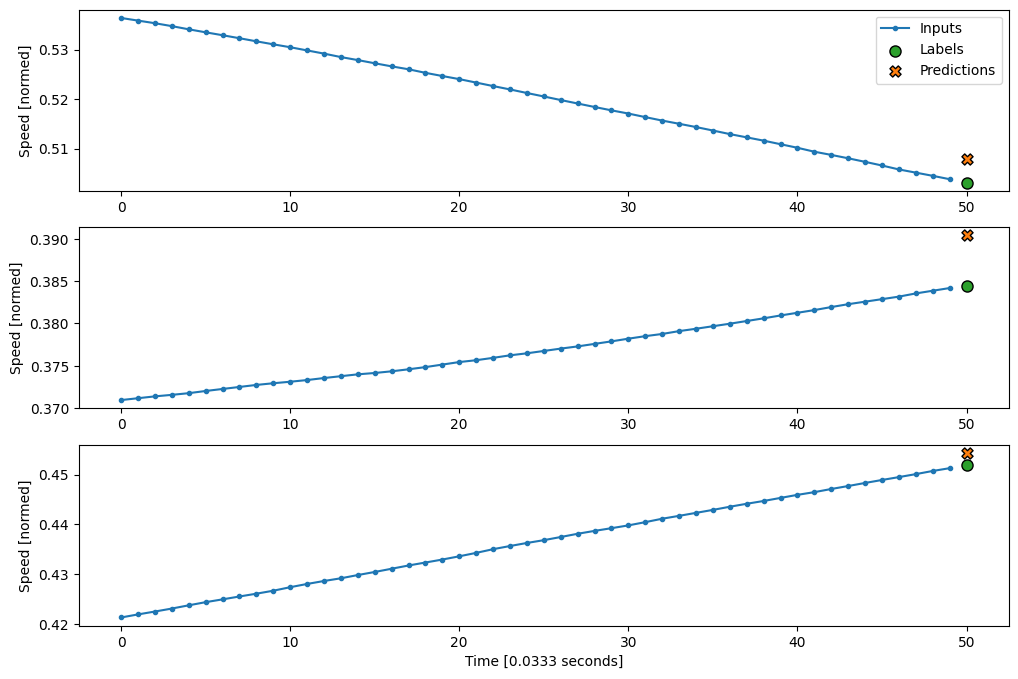

In [23]:
# Convolution Neural Network
# Same as the dense model except Flatten and first dense are replaced by Conv1D 
# Reshape is no longer necessary since convolution keeps time axis in output
# Conv_models can be run on inputs of any length, multi-step dense cannot
print(conv_window)

# Create CNN
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),])

print("\nConv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape, '\n')

# Train CNN
history = compile_and_fit(conv_model, conv_window)
# IPython.display.clear_output()

# Evaluate CNN
val_performance['Conv CW'] = conv_model.evaluate(conv_window.val)
performance['Conv CW'] = conv_model.evaluate(conv_window.test, verbose=0)
print("\nPerformance:", performance['Conv CW'], 
      "Val Performance:", val_performance['Conv CW'])

# Plot CNN
conv_window.plot(conv_model)

# Save CNN

In [24]:
# Output is shorter than input to train/plot, we need labels and prediction 
# to have same length
# WindowGenerator produces wide windows with extra input time steps so
# the label/prediction lengths match

# Makes 50 time step predictions, given 99 (100 - 1) time step of history
LABEL_WIDTH = 50
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Speed'])

wide_conv_window

Total window size: 100
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98]
Label indices: [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]
Label column name(s): ['Speed']

In [25]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 99, 10)
Labels shape: (32, 50, 1)
Output shape: (32, 50, 1)


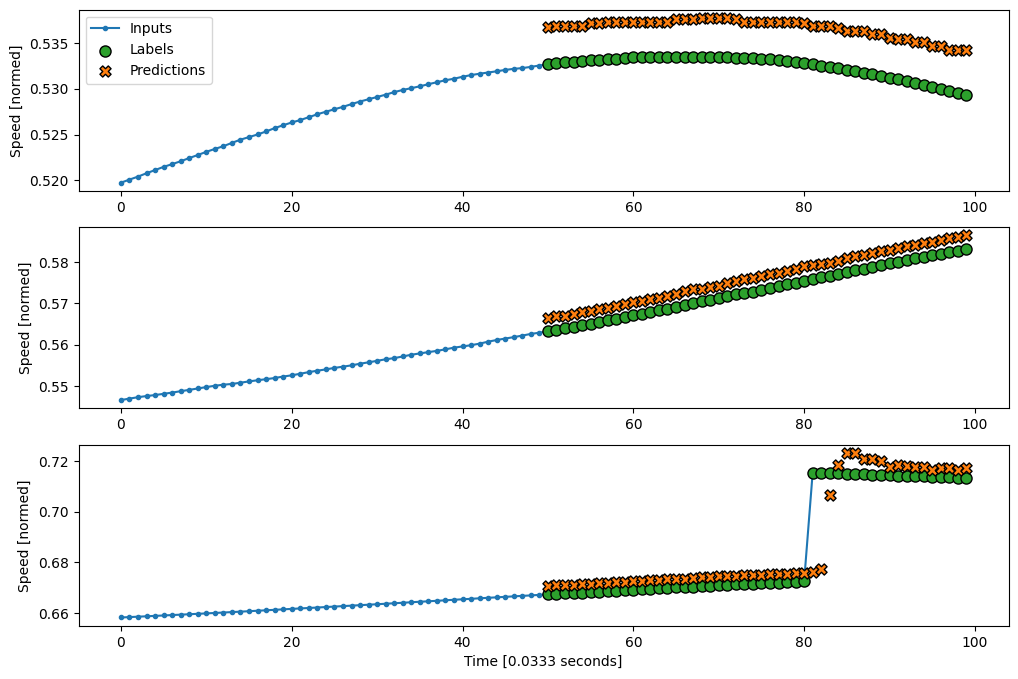

In [26]:
wide_conv_window.plot(conv_model)

Total window size: 51
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
Label column name(s): ['Speed']

Input shape: (32, 50, 10)
Output shape: (32, 50, 1) 

Epoch 1/20
32632/32632 [==============================] - 190s 6ms/step - loss: 2.2374e-04 - mean_absolute_error: 0.0029 - val_loss: 4.9287e-05 - val_mean_absolute_error: 0.0016
Epoch 2/20
32632/32632 [==============================] - 185s 6ms/step - loss: 4.3953e-05 - mean_absolute_error: 0.0012 - val_loss: 4.8622e-05 - val_mean_absolute_error: 0.0011
Epoch 3/20
32632/32632 [==============================] - 187s 6ms/step - loss: 4.3504e-05 - mean_absolute_error: 0.0011 - val_loss: 4.8915e-05 - val_mean_absolute_error: 0.0014
Epoch 4/20
32632/32

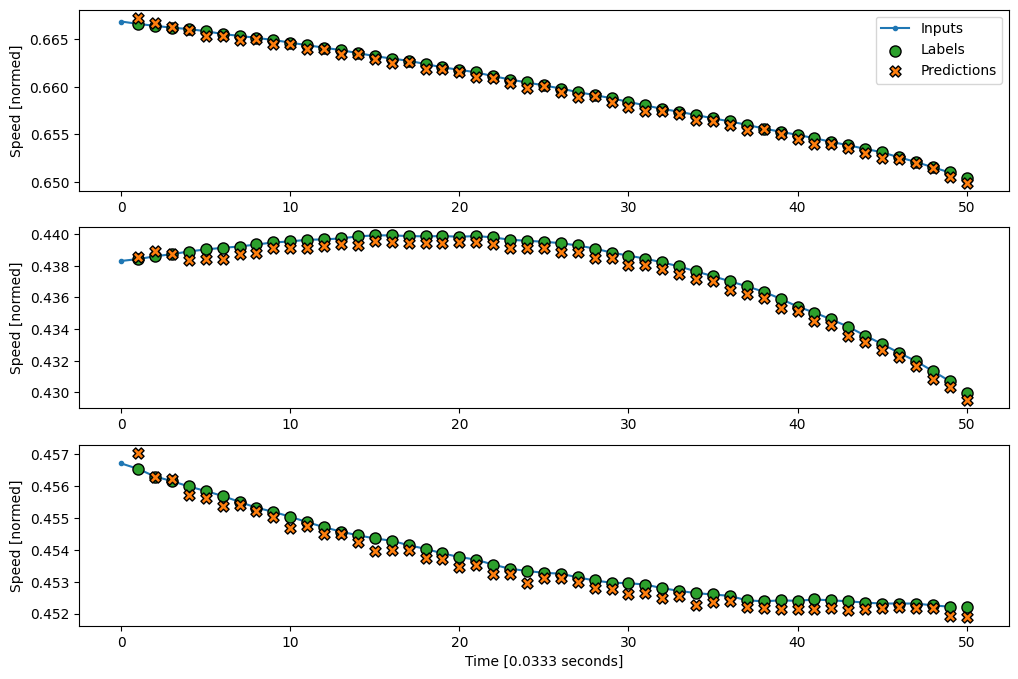

In [27]:
# Recurrent Neural Network
# Well suited for time series data, process a time series step-by-step
# maintaining an internal state from time-step to time-step


# Random Note
# return_sequence = false, default, layer only returns output of final time step
# giving model time to warm up internal state before making single prediction
# return_sequence = true, layer returns outfor for each input
# useful for stacking RNN layers, training model on multiple time steps simultaneously

# Long Short Term Memory Model

# This generates 50 time steps of consecutive inputs and labels at a time
# This doesn't change the way the model operates.
# Still makes 1 time step predictions, given 1 time step of history
# each prediction is made independently
wide_window = WindowGenerator(
    input_width=50, 
    label_width=50, 
    shift=1, 
    label_columns=['Speed'])

print(wide_window)

# Create LSTM Model
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # return_sequences = true, model can be trained on 24 hours of data at a time
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)])

print('\nInput shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape, '\n')

# Train LSTM Model
history = compile_and_fit(lstm_model, wide_window)
# IPython.display.clear_output()

# Evaluate LSTM Model
val_performance['LSTM WW'] = lstm_model.evaluate(wide_window.val)
performance['LSTM WW'] = lstm_model.evaluate(wide_window.test, verbose=0)
print("\nPerformance:", performance['Conv CW'], 
      "Val Performance:", val_performance['Conv CW'])

# Plot LSTM Model
wide_window.plot(lstm_model)

Multi Step Dense CW: 0.0101
Conv CW     : 0.0063
LSTM WW     : 0.0011



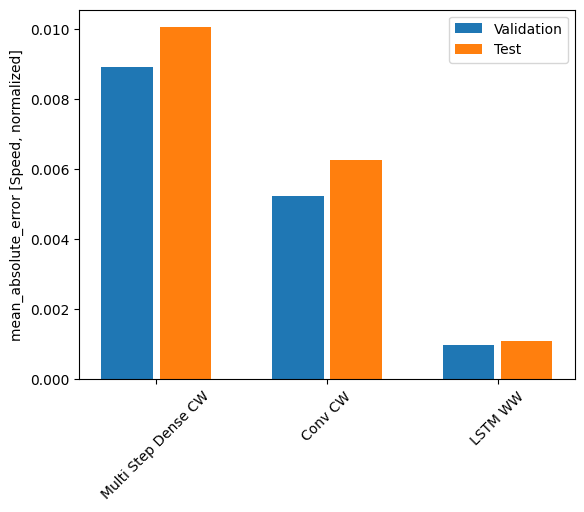

In [28]:
# Performance comparison of each model
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

print()

x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Speed, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

Total window size: 100
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]
Label column name(s): None

Input shape: (32, 50, 10)
Output shape: (32, 50, 10) 

9321/9321 [==============================] - 17s 2ms/step - loss: 0.0059 - mean_absolute_error: 0.0205

Performance: [0.00504010496661067, 0.018928691744804382] Val Performance: [0.005936617497354746, 0.020518695935606956]


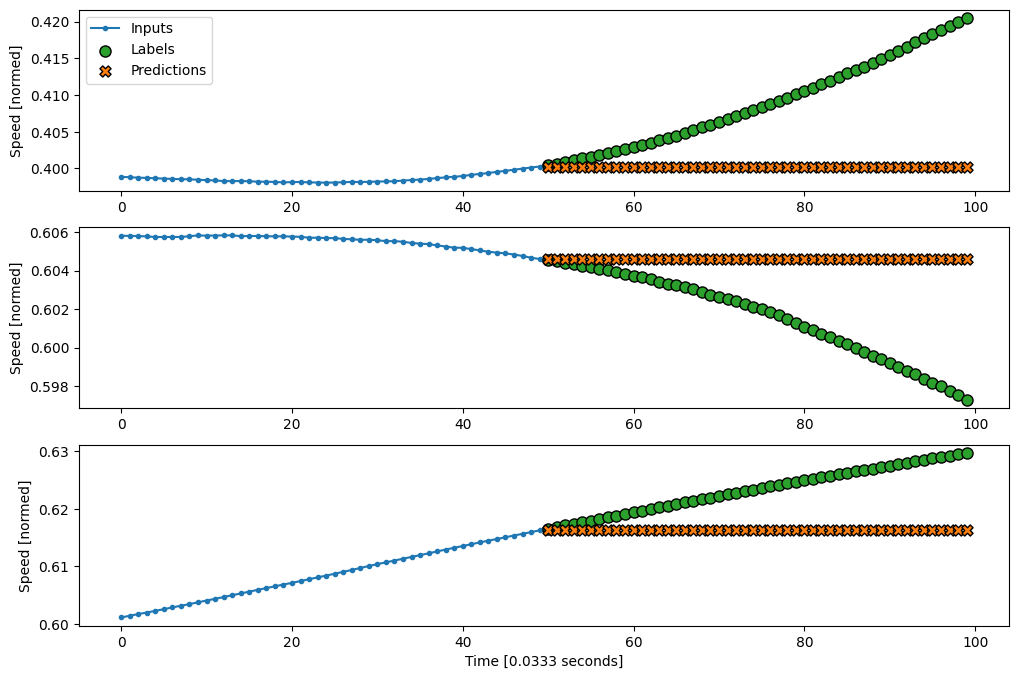

In [31]:
# These models perform worse than the single step predictions.


# Multi-Step Models
# These models will make multiple time step predictions instead of 1 time step

# Initialize dict to store performance values
multi_val_performance = {}
multi_performance = {}

# Baseline
# Repeats last input time step for required number of output time steps
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

# Makes 50 time step predictions, given 50 time step of history
OUT_STEPS = 50
multi_window = WindowGenerator(
    input_width=50, 
    label_width=OUT_STEPS, 
    shift=OUT_STEPS)

print(multi_window)

# Create Baseline Model
last_baseline = MultiStepLastBaseline()

print('\nInput shape:', multi_window.example[0].shape)
print('Output shape:', last_baseline(multi_window.example[0]).shape, '\n')


# Train Baseline Model
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Evaluate Baseline Model
multi_val_performance['Last Baseline MW'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last Baseline MW'] = last_baseline.evaluate(multi_window.test, verbose=0)
print("\nPerformance:", multi_performance['Last Baseline MW'], 
      "Val Performance:", multi_val_performance['Last Baseline MW'])

# Plot Baseline Model
multi_window.plot(last_baseline)

Total window size: 100
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]
Label column name(s): None

Input shape: (32, 50, 10)
Output shape: (32, 50, 10) 

9321/9321 [==============================] - 17s 2ms/step - loss: 0.0115 - mean_absolute_error: 0.0376

Performance: [0.009809327311813831, 0.034454941749572754] Val Performance: [0.011472047306597233, 0.037599220871925354]


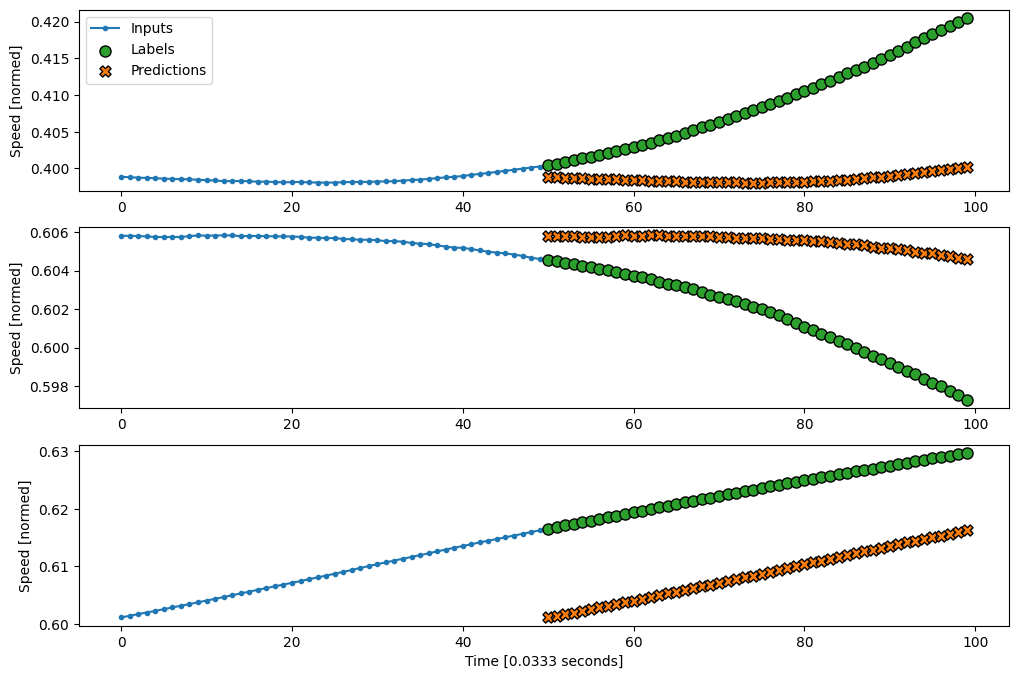

In [32]:
# Repeat Baseline
# Repeats the previous day, assuming tomorrow will be similar
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

print(multi_window)

# Create Repeat Baseline Model
repeat_baseline = RepeatBaseline()

print('\nInput shape:', multi_window.example[0].shape)
print('Output shape:', last_baseline(multi_window.example[0]).shape, '\n')

# Train Repeat Baseline Model
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Evaluate Repeat Baseline Model
multi_val_performance['Repeat Baseline MW'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat Baseline MW'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
print("\nPerformance:", multi_performance['Repeat Baseline MW'], 
      "Val Performance:", multi_val_performance['Repeat Baseline MW'])

# Plot Repeat Baseline Model
multi_window.plot(repeat_baseline)

Total window size: 100
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]
Label column name(s): None

Input shape: (32, 50, 10)
Output shape: (32, 50, 10) 

Epoch 1/20
32631/32631 [==============================] - 105s 3ms/step - loss: 0.0057 - mean_absolute_error: 0.0248 - val_loss: 0.0053 - val_mean_absolute_error: 0.0224
Epoch 2/20
32631/32631 [==============================] - 104s 3ms/step - loss: 0.0050 - mean_absolute_error: 0.0206 - val_loss: 0.0053 - val_mean_absolute_error: 0.0225
Epoch 3/20
32631/32631 [==============================] - 105s 3ms/step - loss: 0.0050 - mean_absolute_error: 0.0205 - val_loss: 0.0053 - val_mean_absolute_error: 0.0224
Epoch 4/20
32631/32631 [======================

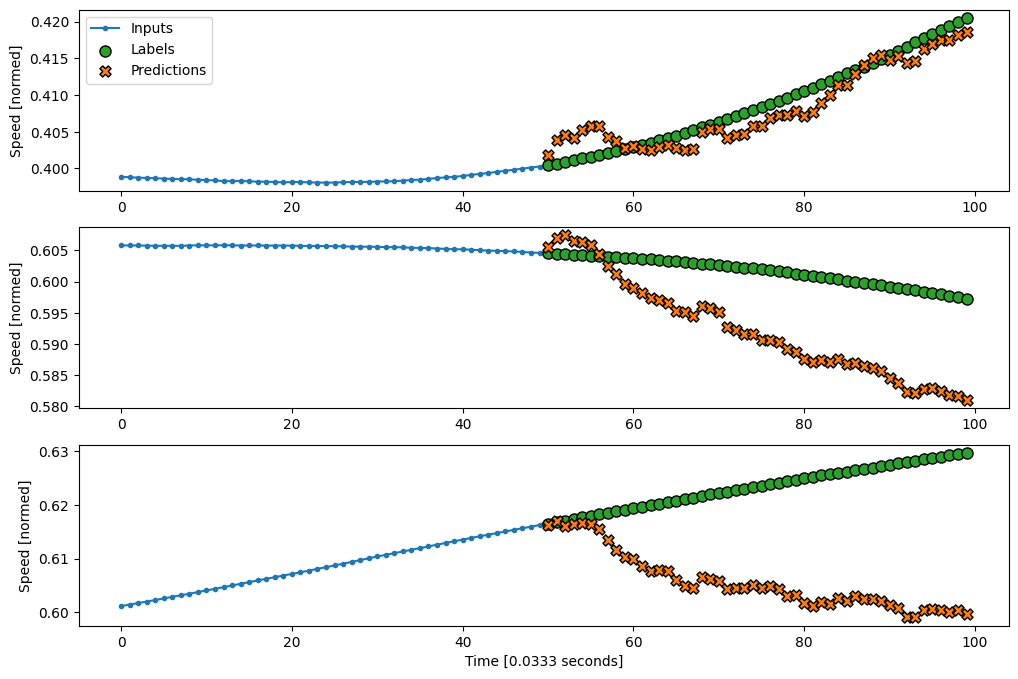

In [33]:
# Single Shot Models
# Makes entire sequence prediction in single step

# Multi Linear Model
print(multi_window)

# Create Multi Linear Model
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])])

print('\nInput shape:', multi_window.example[0].shape)
print('Output shape:', multi_linear_model(multi_window.example[0]).shape, '\n')

# Train Multi Linear Model
history = compile_and_fit(multi_linear_model, multi_window)
# IPython.display.clear_output()

# Evaluate Multi Linear Model
multi_val_performance['Single Shot Multi Linear MW'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Single Shot Multi Linear MW'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
print("\nPerformance:", multi_performance['Single Shot Multi Linear MW'], 
      "Val Performance:", multi_val_performance['Single Shot Multi Linear MW'])

# Plot Multi Linear Model
multi_window.plot(multi_linear_model)

Total window size: 100
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]
Label column name(s): None

Input shape: (32, 50, 10)
Output shape: (32, 50, 10) 

Epoch 1/20
32631/32631 [==============================] - 127s 4ms/step - loss: 0.0037 - mean_absolute_error: 0.0206 - val_loss: 0.0045 - val_mean_absolute_error: 0.0277
Epoch 2/20
32631/32631 [==============================] - 126s 4ms/step - loss: 0.0032 - mean_absolute_error: 0.0182 - val_loss: 0.0054 - val_mean_absolute_error: 0.0261
Epoch 3/20
9321/9321 [==============================] - 24s 3ms/step - loss: 0.0069 - mean_absolute_error: 0.0298

Performance: [0.019991165027022362, 0.06363386660814285] Val Performance: [0.006868740543723106, 0.02

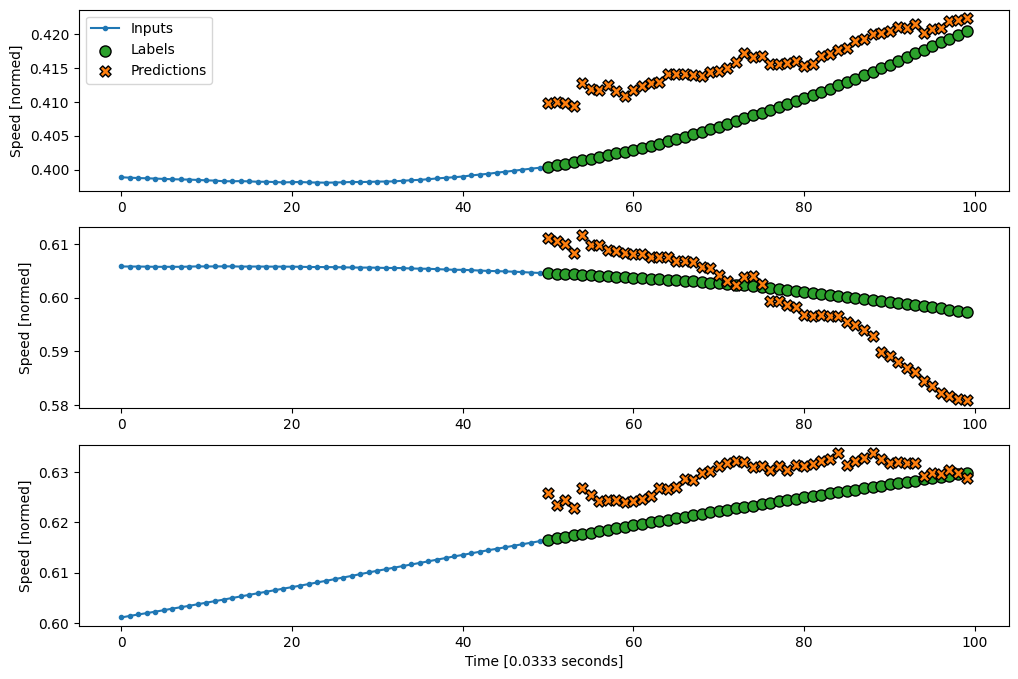

In [34]:
# Multi Dense Model
# Adding dense layer between input and output gives model more power
print(multi_window)

# Create Multi Dense Model
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])])

print('\nInput shape:', multi_window.example[0].shape)
print('Output shape:', multi_dense_model(multi_window.example[0]).shape, '\n')

# Train Multi Dense Model
history = compile_and_fit(multi_dense_model, multi_window)
# IPython.display.clear_output()

# Evaluate Multi Dense Model
multi_val_performance['Single Shot Multi Dense MW'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Single Shot Multi Dense MW'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
print("\nPerformance:", multi_performance['Single Shot Multi Dense MW'], 
      "Val Performance:", multi_val_performance['Single Shot Multi Dense MW'])

# Plot Multi Dense Model
multi_window.plot(multi_dense_model)

Total window size: 100
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]
Label column name(s): None

Input shape: (32, 50, 10)
Output shape: (32, 50, 10) 

Epoch 1/20
32631/32631 [==============================] - 122s 4ms/step - loss: 0.0038 - mean_absolute_error: 0.0222 - val_loss: 0.0048 - val_mean_absolute_error: 0.0275
Epoch 2/20
32631/32631 [==============================] - 121s 4ms/step - loss: 0.0033 - mean_absolute_error: 0.0190 - val_loss: 0.0044 - val_mean_absolute_error: 0.0261
Epoch 3/20
32631/32631 [==============================] - 121s 4ms/step - loss: 0.0032 - mean_absolute_error: 0.0183 - val_loss: 0.0044 - val_mean_absolute_error: 0.0229
Epoch 4/20
32631/32631 [======================

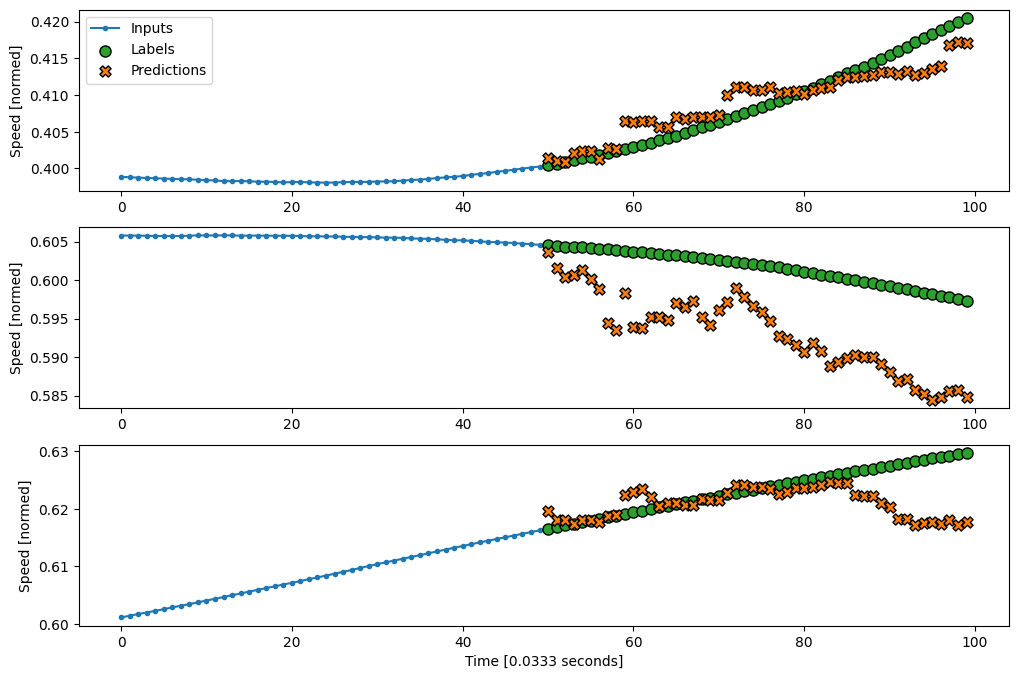

In [35]:
# Convolutional Neural Network
# Makes predictions based on fixed width history, may lead to better performance
# than dense model since it can see how things change over time

print(multi_window)

# Create CNN
CONV_WIDTH = 25 
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])])

print('\nInput shape:', multi_window.example[0].shape)
print('Output shape:', multi_conv_model(multi_window.example[0]).shape, '\n')

# Train CNN
history = compile_and_fit(multi_conv_model, multi_window)
# IPython.display.clear_output()

# Evaluate CNN
multi_val_performance['CNN MW'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['CNN MW'] = multi_conv_model.evaluate(multi_window.test, 
                                                        verbose=0)
print("\nPerformance:", multi_performance['CNN MW'], 
      "Val Performance:", multi_val_performance['CNN MW'])

# Plot CNN
multi_window.plot(multi_conv_model)

Total window size: 100
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]
Label column name(s): None

Input shape: (32, 50, 10)
Output shape: (32, 50, 10) 

Epoch 1/20
32631/32631 [==============================] - 179s 5ms/step - loss: 0.0035 - mean_absolute_error: 0.0193 - val_loss: 0.0033 - val_mean_absolute_error: 0.0196
Epoch 2/20
32631/32631 [==============================] - 176s 5ms/step - loss: 0.0026 - mean_absolute_error: 0.0144 - val_loss: 0.0032 - val_mean_absolute_error: 0.0183
Epoch 3/20
32631/32631 [==============================] - 174s 5ms/step - loss: 0.0025 - mean_absolute_error: 0.0136 - val_loss: 0.0031 - val_mean_absolute_error: 0.0182
Epoch 4/20
32631/32631 [======================

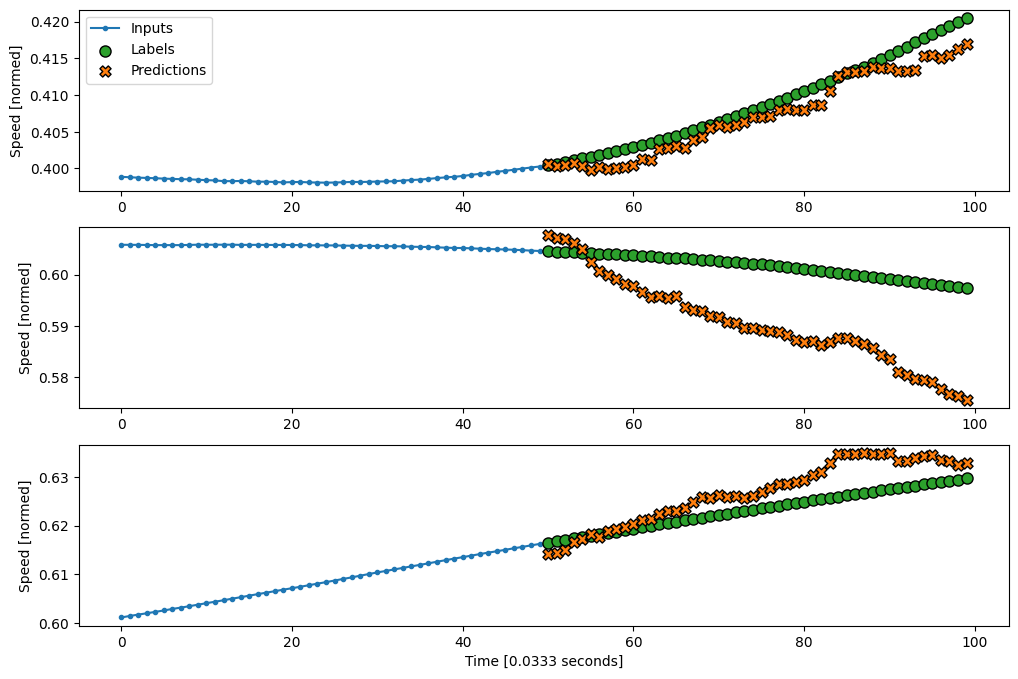

In [36]:
# Recurrent Neural Network
# Learns to use long history of inputs if relevant to predictions
# Accumulates 50 time steps before making a single prediction for 50 time steps

print(multi_window)

# Create RNN LSTM Model
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])])

print('\nInput shape:', multi_window.example[0].shape)
print('Output shape:', multi_lstm_model(multi_window.example[0]).shape, '\n')

# Train RNN LSTM Model
history = compile_and_fit(multi_lstm_model, multi_window)
# IPython.display.clear_output()

# Evaluate RNN LSTM Model
multi_val_performance['LSTM MW'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM MW'] = multi_lstm_model.evaluate(multi_window.test, 
                                                         verbose=0)
print("\nPerformance:", multi_performance['LSTM MW'], 
      "Val Performance:", multi_val_performance['LSTM MW'])

# Plot RNN LSTM
multi_window.plot(multi_lstm_model)

In [37]:
# Autoregressive Model
# Decomposes prediction into individual time steps, feeds output back into 
# itself at each step and prediction can be conditioned to the previous one

# Any single step multi-output model can be fed into an Autoregreesive loop
# Recurrent Neural Network is explicitly trained to do this though

# Model must manage inputs for each step
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

# Model requires a "warmup" to initialize internal state based on inputs
# equivalent to Single Step LSTM model from above
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

# Iterates the model feeding the predictions at each step back as input
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

Total window size: 100
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]
Label column name(s): None

Input shape: (32, 50, 10)
Output shape: (32, 50, 10) 

Epoch 1/20
32631/32631 [==============================] - 2671s 82ms/step - loss: 0.0046 - mean_absolute_error: 0.0303 - val_loss: 0.0049 - val_mean_absolute_error: 0.0328
Epoch 2/20
32631/32631 [==============================] - 2658s 81ms/step - loss: 0.0032 - mean_absolute_error: 0.0212 - val_loss: 0.0040 - val_mean_absolute_error: 0.0291
Epoch 3/20
32631/32631 [==============================] - 2670s 82ms/step - loss: 0.0027 - mean_absolute_error: 0.0175 - val_loss: 0.0037 - val_mean_absolute_error: 0.0259
Epoch 4/20
32631/32631 [================

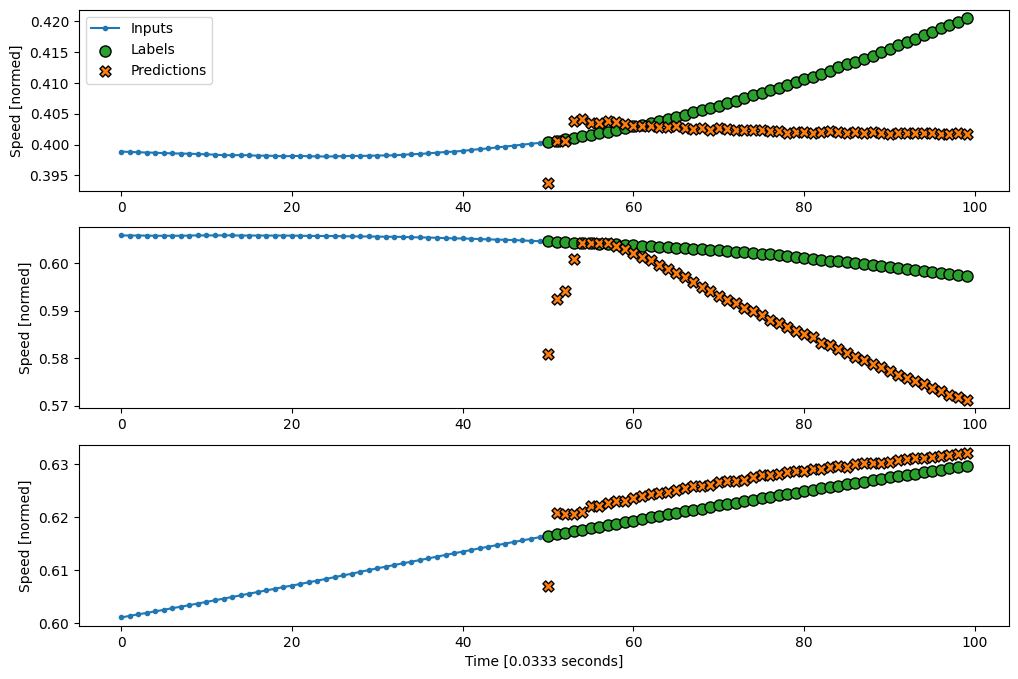

In [38]:
# Feedback Model
print(multi_window)

# Create Feedback Model
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
FeedBack.warmup = warmup
FeedBack.call = call

print('\nInput shape:', multi_window.example[0].shape)
print('Output shape:', multi_lstm_model(multi_window.example[0]).shape, '\n')

# Train Feedback Model
history = compile_and_fit(feedback_model, multi_window)
# IPython.display.clear_output()

# Evaluate Feedback Model
multi_val_performance['AR LSTM MW'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM MW'] = feedback_model.evaluate(multi_window.test, 
                                                          verbose=0)
print("\nPerformance:", multi_performance['AR LSTM MW'], 
      "Val Performance:", multi_val_performance['AR LSTM MW'])

# Plot Feedback Model
multi_window.plot(feedback_model)

Last Baseline MW: 0.0189
Repeat Baseline MW: 0.0345
Single Shot Multi Linear MW: 0.0227
Single Shot Multi Dense MW: 0.0636
CNN MW  : 0.0401
LSTM MW : 0.0291
AR LSTM MW: 0.0546


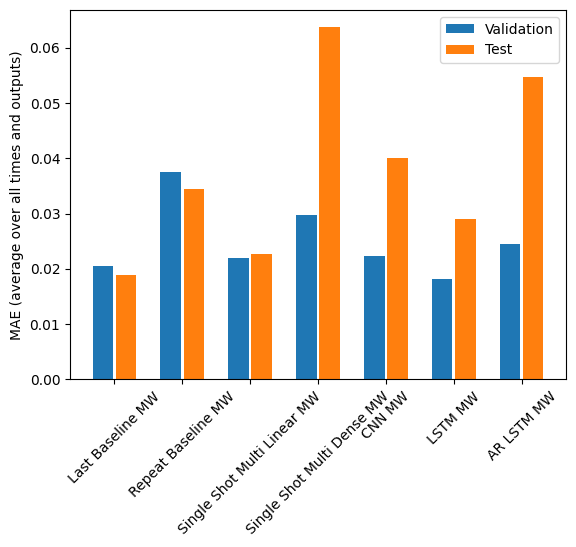

In [39]:
# Display performance of multi step models
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

In [ ]:
# There's no way of knowing which model performs best on the data until tried
# Example: backpropagation (AR LSTM) and Linear both perform poorly
# There's a chance this is due to my SMALL data size